# **Introduction**
This notebook builds upon the exploratory data analysis (EDA), transitioning from descriptive analysis to predictive modeling. The objective is to develop a robust classification model to automatically categorize financial articles from the Reuters-21578 dataset into one of five target topics:

* Money/Foreign Exchange (**MONEY-FX**)
* Shipping (**SHIP**)
* Interest Rates (**INTEREST**)
* Mergers/Acquisitions (**ACQ**)
* Earnings and Earnings Forecasts (**EARN**)


## **Key Objectives:**

1. **Data Preparation:** Leverage the cleaned and preprocessed data from the EDA phase, ensuring compatibility with machine learning workflows.
2. **Model Development:**
  * Implement text vectorization (TF-IDF).
  * Explore various machine learning algorithms, with a focus on text classification techniques.
3. **Performance Evaluation:** Assess model effectiveness using metrics such as accuracy, precision, recall, and F1-score, to identify the best-performing algorithm.

## **Outcome:**
By the end of this notebook, a trained classification model will be ready to predict article topics with high accuracy.

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (classification_report,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix)
from sklearn.model_selection import cross_val_score

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Data preparation**

In [2]:
file_path = '/content/drive/MyDrive/topics_classification_dataset.csv'
df = pd.read_csv(file_path)
df

,LEWISSPLIT,Text,Topics
0,TRAIN,JAGUAR SEES STRONG GROWTH IN NEW MODEL SALES J...,earn
1,TRAIN,NORD RESOURCES CORP <NRD> 4TH QTR NET Shr 19 c...,earn
2,TRAIN,FIVE GROUPS APPLY TO BUY FRENCH TELEPHONE GROU...,acq
3,TRAIN,BLIZZARD CLOSES BOSPHORUS Blizzard conditions ...,ship
4,TRAIN,JAPAN FUND <JPN> SEEKERS CONFIDENT OF FINANCIN...,acq
...,...,...,...
7052,TRAIN,BAKER INTERNATIONAL CORP SUES HUGHES TOOL SEEK...,acq
7053,TRAIN,USAIR GROUP REJECTS TRANS WORLD AIRLINES TAKEO...,acq
7054,TRAIN,BAKER <BKO> SUES TO FORCE HUGHES <HT> MERGER B...,acq
7055,TRAIN,SPAIN DEREGULATES BANK DEPOSIT INTEREST RATES ...,interest


This `preprocess_text` function preprocesses raw text to prepare it for machine learning. It performs the following steps:

* Remove URLs: Strips out any web links.
* Remove HTML Tags: Cleans up HTML elements that might be present in the text.
* Remove Special Characters, Numbers, and Punctuation.
* Convert to Lowercase.
* Remove Stopwords and Single-character Words.

In [3]:
def preprocess_text(text):
    # remove url links
    text = re.sub("http\s+", '', text)
    # remove html tags
    text = re.sub("<[^<]+?>", '', text)
    # remove special characters, numbers and punctuations
    text = re.sub("[^A-za-z+ ]", ' ', text)
    # lower the text
    text = text.lower()
    # remove stopwords and words that have length of 1
    text = " ".join(word for word in nltk.wordpunct_tokenize(text) if len(word)!=1 and word not in stop_words)

    return text

Next we prepare our data by spliting the dataset into training and testing sets and preprocessing it.

In [4]:
# Extract and preprocess text for training
X_train = [
    row['Text']
    for _, row in df[df['LEWISSPLIT'] == "TRAIN"].iterrows()
]

X_train = [preprocess_text(str(text)) for text in X_train]

# Extract the labels
y_train = df[df['LEWISSPLIT'] == "TRAIN"]['Topics'].tolist()


In [5]:
# Extract and preprocess text for testing
X_test = [
    row['Text']
    for _, row in df[df['LEWISSPLIT'] == "TEST"].iterrows()
]
X_test = [preprocess_text(str(text)) for text in X_test]

# Extract the labels
y_test = df[df['LEWISSPLIT'] == "TEST"]['Topics'].tolist()

# **Trainnig and evaluation**

The `evaluate_models_without_smote` function evaluates the performance of four classification algorithms on the provided dataset. The algorithms used include:
* **Naive Bayes.**
* **Random Forest**.
* **Logistic Regression.**
* **Support Vector Machine (SVM)**

 Each model is trained using a pipeline with **TF-IDF** vectorization, and their performance is assessed using cross-validation and various metrics, including accuracy, precision, recall, and F1-score.

In [6]:
def evaluate_models_without_smote(X_train, X_test, y_train, y_test):
    """
    Evaluates multiple classification models and returns a DataFrame of results.

    Parameters:
    X_train (array-like): Training feature data.
    X_test (array-like): Testing feature data.
    y_train (array-like): Training labels.
    y_test (array-like): Testing labels.

    Returns:
    pd.DataFrame: A DataFrame with evaluation metrics for each model.
    """
    # Dictionary of models
    models = {
        "Naive Bayes": MultinomialNB(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "SVM": SVC(kernel='linear', random_state=42)
    }

    # results dictionary
    results = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")

        # Create pipeline
        pipeline = make_pipeline(TfidfVectorizer(), model)

        # Cross-validation
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted')

        # Train and evaluate on test data
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred))

        # results
        results[model_name] = {
            "Cross-Val F1": np.mean(scores),
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }

    results_df = pd.DataFrame(results).T

    return results_df


In [7]:
results_df = evaluate_models_without_smote(X_train, X_test, y_train, y_test)
print(results_df)


Evaluating Naive Bayes...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

         acq       0.84      0.96      0.90       696
        earn       0.93      0.99      0.96      1084
    interest       1.00      0.18      0.31        82
    money-fx       0.77      0.23      0.35        87
        ship       0.00      0.00      0.00        36

    accuracy                           0.89      1985
   macro avg       0.71      0.47      0.50      1985
weighted avg       0.88      0.89      0.87      1985

Evaluating Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

         acq       0.92      0.98      0.95       696
        earn       0.98      0.99      0.99      1084
    interest       0.93      0.76      0.83        82
    money-fx       0.84      0.66      0.74        87
        ship       1.00      0.47      0.64        36

    accuracy                           0.95      1985
   macro avg       0.93

In [8]:
results_df

,Cross-Val F1,Accuracy,Precision,Recall,F1-Score
Naive Bayes,0.872128,0.894710,0.879543,0.894710,0.867265
Random Forest,0.941470,0.952141,0.952083,0.952141,0.949166
Logistic Regression,0.945111,0.950126,0.950168,0.950126,0.945968
SVM,0.966791,0.975819,0.975749,0.975819,0.975468


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_metrics(results_df,text):
    """
    Plots a bar chart to compare model metrics from the evaluation results.

    Parameters:
    results_df (pd.DataFrame): DataFrame containing evaluation metrics for models.
    """
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "Cross-Val F1"]
    models = results_df.index
    x = np.arange(len(metrics))

    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))

    # Generate bars for each model
    for i, model in enumerate(models):
        ax.bar(x + i * width, results_df.loc[model, metrics], width, label=model)
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f"Comparison of Model Performance Metrics ({text})")
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.legend()

    for i, model in enumerate(models):
        for j, value in enumerate(results_df.loc[model, metrics]):
            ax.text(x[j] + i * width, value + 0.01, f"{value:.2f}", ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()


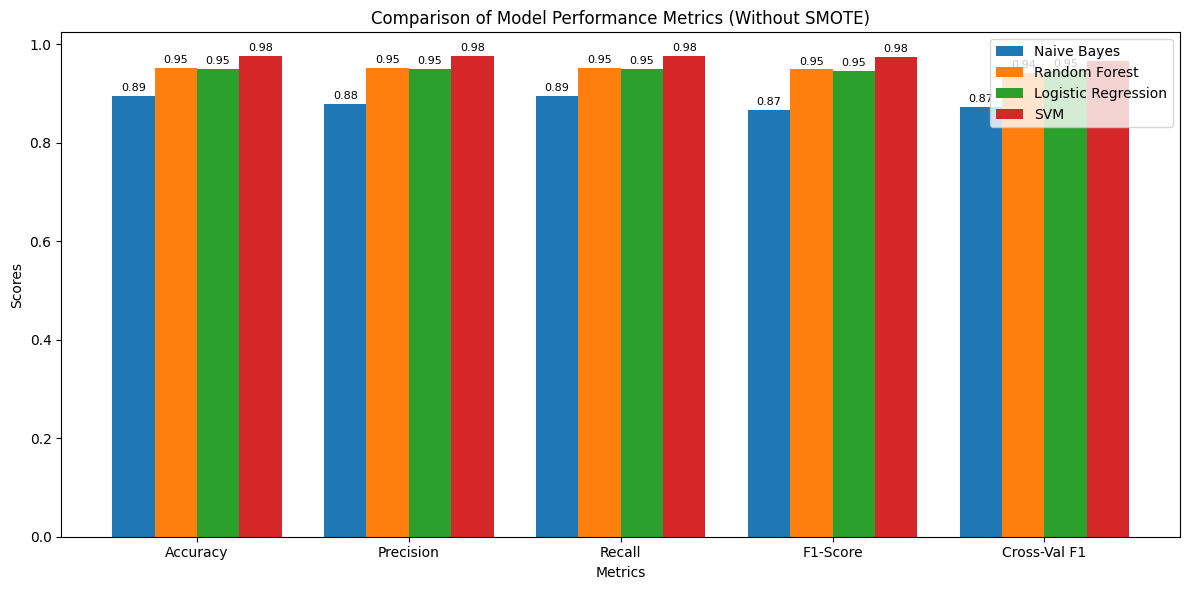

In [10]:
plot_model_metrics(results_df,"Without SMOTE")

**Comparison and Interpretation**

* All models perform exceptionally well on the majority classes ('acq' and 'earn') due to the abundance of training data.
* Minority Classes Challenge: Models differ significantly in handling minority classes ('interest', 'money-fx', 'ship').
* Naive Bayes struggles the most, with zero recall on 'ship'.
* Random Forest and Logistic Regression show moderate improvements.
* SVM outperforms others, achieving high precision and recall even on minority classes.

## **SMOTE**

SMOTE is an over-sampling technique used to balance class distributions by generating synthetic samples for minority classes. It works by:

Selecting a minority class instance.
Finding its nearest minority class neighbors.
Creating synthetic samples along the line segments joining the minority instances.

In [11]:
def evaluate_models_with_smote(X_train, X_test, y_train, y_test, random_state=42):
    """
    Evaluates multiple classification models with SMOTE and returns a DataFrame of results.

    Parameters:
    X_train (array-like): Training feature data.
    X_test (array-like): Testing feature data.
    y_train (array-like): Training labels.
    y_test (array-like): Testing labels.
    random_state (int): Random state for SMOTE.

    Returns:
    pd.DataFrame: A DataFrame with evaluation metrics for each model.
    """
    # Dictionary of models
    models = {
        "Naive Bayes": MultinomialNB(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=random_state),
        "SVM": SVC(kernel='linear', random_state=random_state, probability=True)
    }

    # results dictionary
    results = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")

        # Create pipeline with SMOTE
        pipeline = ImbPipeline([
            ('tfidf', TfidfVectorizer()),  # Text vectorization
            ('smote', SMOTE(random_state=random_state)),  # Oversampling
            ('classifier', model)  # Classifier
        ])

        # Cross-validation (5-fold)
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted')

        # Train and evaluate on test data
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred))

        # results
        results[model_name] = {
            "Cross-Val F1": np.mean(scores),
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }

    results_df = pd.DataFrame(results).T

    return results_df

In [12]:
results_df_with_smote = evaluate_models_with_smote(X_train, X_test, y_train, y_test)
print(results_df_with_smote)


Evaluating Naive Bayes...
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

         acq       0.97      0.98      0.98       696
        earn       1.00      0.97      0.98      1084
    interest       0.86      0.79      0.82        82
    money-fx       0.78      0.95      0.86        87
        ship       0.95      0.97      0.96        36

    accuracy                           0.97      1985
   macro avg       0.91      0.93      0.92      1985
weighted avg       0.97      0.97      0.97      1985

Evaluating Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

         acq       0.93      0.99      0.96       696
        earn       0.99      0.98      0.99      1084
    interest       0.96      0.79      0.87        82
    money-fx       0.83      0.77      0.80        87
        ship       1.00      0.69      0.82        36

    accuracy                           0.96      19

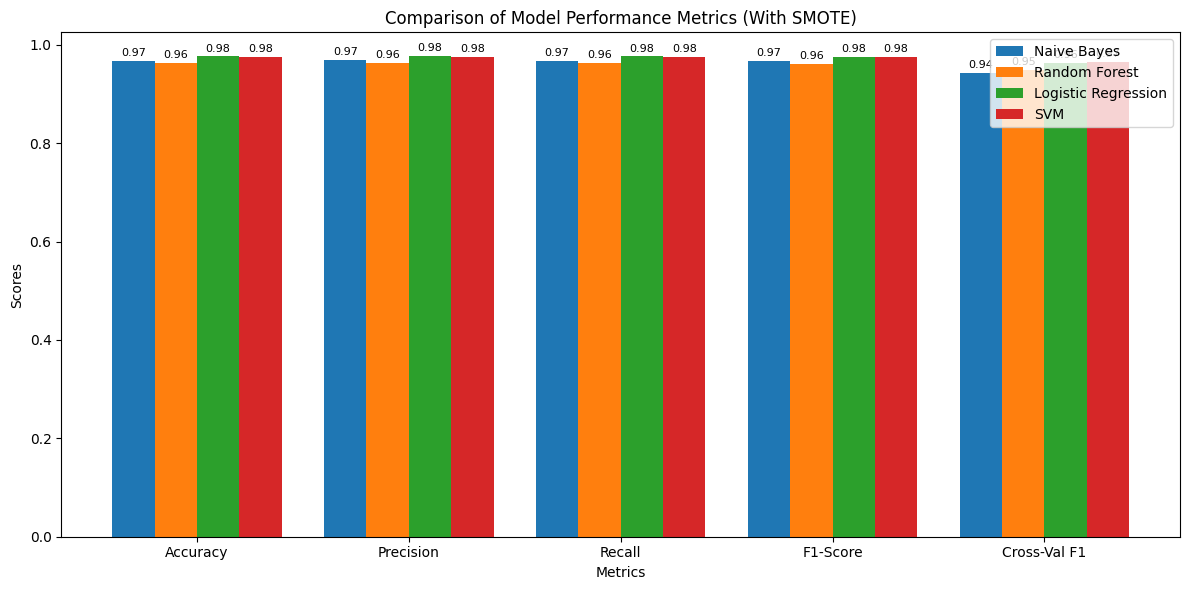

In [13]:
plot_model_metrics(results_df_with_smote,"With SMOTE")

In [14]:
results_df_with_smote

,Cross-Val F1,Accuracy,Precision,Recall,F1-Score
Naive Bayes,0.943382,0.967758,0.969595,0.967758,0.968141
Random Forest,0.949647,0.962720,0.963342,0.962720,0.961836
Logistic Regression,0.962995,0.976322,0.976591,0.976322,0.976275
SVM,0.965357,0.975819,0.976203,0.975819,0.975544


**Comparative Analysis**

**Impact of SMOTE:**

Enhanced Minority Class Performance: All models show significant improvements in precision, recall, and F1-scores for minority classes.
Reduced Class Imbalance Bias: Models are no longer skewed towards majority classes.

**Model-Specific Observations:**

* **Naive Bayes:**
  * Dramatic improvement, now competitive with more complex models.
  * High recall for 'money-fx' and 'ship', indicating effective identification of these classes.
* **Random Forest:**
  * Slightly lower performance compared to others.
  * High precision but somewhat lower recall for minority classes.
* **Logistic Regression:**
  * Strong balance between precision and recall.
  * High F1-scores across all classes.
* **SVM:**
  * Highest overall performance.
  * Excellent precision, minimizing false positives.
  * Slightly lower recall for 'ship', but overall strong minority class performance.

# **SMOTE with Custom Sampling**

**Reasons for Custom Sampling:**

* Avoid Overfitting: By not excessively oversampling minority classes to match


* the majority class counts, you reduce the risk of overfitting to synthetic data.
* Reflect Realistic Class Distributions: Maintaining some level of class imbalance can sometimes better reflect real-world data distributions, ensuring the model remains practical for real applications.
* Focus on Critical Classes: Increasing counts based on the importance or difficulty of classes.

In [15]:
def evaluate_models_with_custom_smote(X_train, X_test, y_train, y_test, sampling_strategy, random_state=42):
    """
    Evaluates multiple classification models with a custom SMOTE sampling strategy and returns a DataFrame of results.

    Parameters:
    X_train (array-like): Training feature data.
    X_test (array-like): Testing feature data.
    y_train (array-like): Training labels.
    y_test (array-like): Testing labels.
    sampling_strategy (dict): Custom sampling strategy for SMOTE.
    random_state (int): Random state for SMOTE.

    Returns:
    pd.DataFrame: A DataFrame with evaluation metrics for each model.
    """
    # Dictionary of models
    models = {
        "Naive Bayes": MultinomialNB(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=random_state),
        "SVM": SVC(kernel='linear', random_state=random_state)
    }

    # results dictionary
    results = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")

        # Create pipeline with SMOTE
        pipeline = ImbPipeline([
            ('tfidf', TfidfVectorizer()),
            ('smote', SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)),
            ('classifier', model)
        ])

        # Cross-validation (5-fold)
        scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_weighted')

        # Train and evaluate on test data
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test, y_pred))

        # results
        results[model_name] = {
            "Cross-Val F1": np.mean(scores),
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }

    results_df = pd.DataFrame(results).T

    return results_df

In [16]:
sampling_strategy = {
    'earn': 3945,       # *1
    'acq': 2834,        # *1.2
    'money-fx': 614,    # *2
    'interest': 712,    # *2.5
    'ship': 474         # *3
}

results_df_with_custom_strategy = evaluate_models_with_custom_smote(X_train, X_test, y_train, y_test, sampling_strategy)



Evaluating Naive Bayes...
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

         acq       0.96      0.99      0.97       696
        earn       0.99      0.98      0.99      1084
    interest       0.91      0.84      0.87        82
    money-fx       0.87      0.89      0.88        87
        ship       1.00      0.69      0.82        36

    accuracy                           0.97      1985
   macro avg       0.94      0.88      0.91      1985
weighted avg       0.97      0.97      0.97      1985

Evaluating Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

         acq       0.93      0.99      0.96       696
        earn       0.99      0.99      0.99      1084
    interest       0.96      0.79      0.87        82
    money-fx       0.84      0.75      0.79        87
        ship       1.00      0.56      0.71        36

    accuracy                           0.96      19

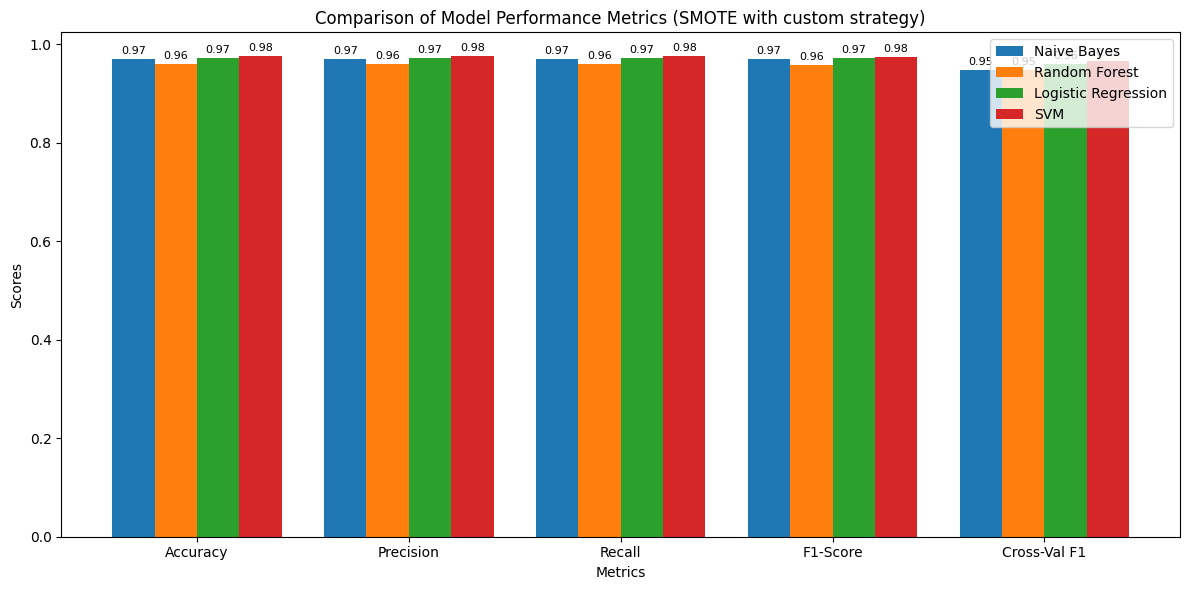

In [17]:
plot_model_metrics(results_df_with_custom_strategy,"SMOTE with custom strategy")

In [18]:
results_df_with_custom_strategy

,Cross-Val F1,Accuracy,Precision,Recall,F1-Score
Naive Bayes,0.948707,0.970277,0.970532,0.970277,0.969768
Random Forest,0.947756,0.960705,0.961004,0.960705,0.958983
Logistic Regression,0.959617,0.972796,0.972747,0.972796,0.972271
SVM,0.967081,0.975819,0.975821,0.975819,0.975483


**Comparative Analysis**

**Impact of Custom SMOTE Strategy:**

* Selective Oversampling: By increasing minority classes to a lesser extent than in full SMOTE, you've mitigated the risk of overfitting while still improving model performance.
* Balanced Improvement: Models have improved on minority classes without compromising performance on majority classes.
* Reflective of Real-World Distributions: Maintaining some class imbalance can help models generalize better to real-world data.

**Model-Specific Observations:**

* **Naive Bayes:**
  * Strong Performance: High precision and recall, especially for 'money-fx' and 'interest'.
  * Lower Recall for 'ship': Despite tripling its count, recall is at 0.72.
* **Random Forest:**
  * High Precision: But lower recall for minority classes compared to other models.
  * Possible Bias: May still favor majority classes.
* **Logistic Regression:**
  * Consistent Performance: Good balance between precision and recall across all classes.
  * Effective Learning: Improved metrics suggest effective use of augmented data.
* **SVM:**
  * Best Overall Performance: Highest accuracy, precision, and recall.
  * Balanced Minority Class Metrics: Indicates robust learning without overfitting.

**Conclusion**

Selecting the appropriate model and SMOTE strategy depends on your specific application needs, resource constraints, and performance requirements. Based on the analyses:

* For the best overall performance, especially on minority classes, use SVM with the custom SMOTE strategy.
* If computational efficiency is a priority, we can use Logistic Regression with the custom SMOTE strategy.
